## Word Tokenizer exercise##

In this exercise, you are going to build a set of deep learning models on a (sort of) real world task using Tensorflow and Keras. Tensorflow is a deep learning framwork developed by Google, and Keras is a frontend library built on top of Tensorflow (or Theano, CNTK) to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for word tokenization in Thai (แบ่งเว้นวรรคภาษาไทย) using NECTEC's BEST corpus. You will build one model for each of the following type:
- Fully Connected (Feedforward) Neural Network
- One-Dimentional Convolution Neural Network (1D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for keras in this notebook but feel free to modify those parts to suit your needs. You can also complete this exercise using only Tensorflow (without using Keras). Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.

As a reminder,

### Don't forget to shut down your instance on Gcloud when you are not using it ###

In [1]:
# Run setup code
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Prepare data
# You don't need to run the following code as we already did it for you to give everyone the same dataset
# import cattern.data_utils
# cattern.data_utils.generate_best_dataset(os.getcwd()+'/data', create_val=True)

For simplicity, we are going to build a word tokenization model which is a binary classification model trying to predict whether a character is the begining of the word or not (if it is, then there is a space in front of it) and without using any knowledge about type of character (vowel, number, English character etc.).

For example,

'แมวดำน่ารักมาก' -> 'แมว ดำ น่า รัก มาก'

will have these true labels:

[(แ,1), (ม,0), (ว,0) (ด,1), ( ำ,0), (น,1), (-่,0), (า,0), (ร,1), (-ั,0), (ก,0), (ม,1), (า,0), (ก,0)]

In this task, we will use only main character you are trying to predict  and the characters that surround it (the context) as features. However, you can imagine that a more complex model will try to include more knowledge about each character into the model. You can do that too if you feel like it.

In [3]:
# Create a character map
CHARS = [
  '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
  ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
  '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
  'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
  'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
  'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
  'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
  'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
  'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
  'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
  'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
  'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
  '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}

In [4]:
def create_n_gram_df(df, n_pad):
  """
  Given an input dataframe, create a feature dataframe of shifted characters
  Input:
  df: timeseries of size (N)
  n_pad: the number of context. For a given character at position [idx],
    character at position [idx-n_pad/2 : idx+n_pad/2] will be used 
    as features for that character.
  
  Output:
  dataframe of size (N * n_pad) which each row contains the character, 
    n_pad_2 characters to the left, and n_pad_2 characters to the right
    of that character.
  """
  n_pad_2 = int((n_pad - 1)/2)
  for i in range(n_pad_2):
      df['char-{}'.format(i+1)] = df['char'].shift(i + 1)
      df['char{}'.format(i+1)] = df['char'].shift(-i - 1)
  return df[n_pad_2: -n_pad_2]

In [5]:
def prepare_feature(best_processed_path, option='train'):
  """
  Transform the path to a directory containing processed files 
  into a feature matrix and output array
  Input:
  best_processed_path: str, path to a processed version of the BEST dataset
  option: str, 'train' or 'test'
  """
  # we use padding equals 21 here to consider 10 characters to the left
  # and 10 characters to the right as features for the character in the middle
  n_pad = 21
  n_pad_2 = int((n_pad - 1)/2)
  pad = [{'char': ' ', 'target': True}]
  df_pad = pd.DataFrame(pad * n_pad_2)

  df = []
  # article types in BEST corpus
  article_types = ['article', 'encyclopedia', 'news', 'novel']
  for article_type in article_types:
      df.append(pd.read_csv(os.path.join(best_processed_path, option, 'df_best_{}_{}.csv'.format(article_type, option))))
  
  df = pd.concat(df)
  # pad with empty string feature
  df = pd.concat((df_pad, df, df_pad))

  # map characters to numbers, use 'other' if not in the predefined character set.
  df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80))

  # Use nearby characters as features
  df_with_context = create_n_gram_df(df, n_pad=n_pad)

  char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
             ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']

  # convert pandas dataframe to numpy array to feed to the model
  x_char = df_with_context[char_row].as_matrix()
  y = df_with_context['target'].astype(int).as_matrix()

  return x_char, y

Before running the following commands, we must inform you that our data is quite large and loading the whole dataset at once will **use a lot of memory (~6 GB after processing and up to ~12GB while processing)**. We expect you to be running this on Google Cloud so that you will not run into this problem. But, if, for any reason, you have to run this on your PC or machine with not enough memory, you might need to write a data generator to process a few entries at a time then feed it to the model while training.

For keras, you can use [fit_generator](https://keras.io/getting-started/faq/#how-can-i-use-keras-with-datasets-that-dont-fit-in-memory) to cope with that.

In [6]:
# Path to the preprocessed data
best_processed_path = 'cleaned_data'

In [7]:
# Load preprocessed BEST corpus
x_train_char, y_train = prepare_feature(best_processed_path, option='train')
x_val_char, y_val = prepare_feature(best_processed_path, option='val')
x_test_char, y_test = prepare_feature(best_processed_path, option='test')

# As a sanity check, we print out the size of the training, val, and test data.
print('Training data shape: ', x_train_char.shape)
print('Training data labels shape: ', y_train.shape)
print('Validation data shape: ', x_val_char.shape)
print('Validation data labels shape: ', y_val.shape)
print('Test data shape: ', x_test_char.shape)
print('Test data labels shape: ', y_test.shape)

Training data shape:  (16461637, 21)
Training data labels shape:  (16461637,)
Validation data shape:  (2035694, 21)
Validation data labels shape:  (2035694,)
Test data shape:  (2271932, 21)
Test data labels shape:  (2271932,)


In [8]:
# Print some entry from the data to make sure it is the same as what you think.
print('First 3 features: ', x_train_char[:3])
print('First 30 class labels', y_train[:30])

First 3 features:  [[ 112.  140.  114.  148.  130.  142.   94.  142.  128.  128.    1.    1.
     1.    1.    1.    1.    1.    1.    1.    1.   97.]
 [ 140.  114.  148.  130.  142.   94.  142.  128.  128.  141.   97.    1.
     1.    1.    1.    1.    1.    1.    1.    1.  112.]
 [ 114.  148.  130.  142.   94.  142.  128.  128.  141.  109.  112.   97.
     1.    1.    1.    1.    1.    1.    1.    1.  140.]]
First 30 class labels [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


Now, you are going to define the model to be used as your classifier. If you are using Keras, please follow the guideline we provide below. We encourage you to use the Keras Funtional API instead of the Sequential model as it is easier to create complex models (and to read your code). You can find more about Keras Functional API on Keras [documentation](https://keras.io/getting-started/functional-api-guide/).

You need to create a function that return a model you want and write code that invoke _**model.fit**_ to train your model. For example, your function ***get_nn()*** might looks like this:

```python
def get_nn():
  input1 = Input(...)
  ...
  # Create your wonderful model.
  ...
  out = ...
  model = Model(inputs=input1, outputs=out)
  model.compile(...)
return model
```

Also, beware that complex model requires more time to train and your dataset is already quite large. We tested it with a simple 1-hidden-layered feedforward nueral network and it used ~10 mins to train 1 epoch. It got more than 95% accuracy on validation set after the first epoch, so you should aim for a model with accuracy around 96-98%.

# Three-Layer Feedforward Neural Networks

Below, we provide you the code for creating a 3-layer fully connected neural network in keras. This will also serve as the baseline for your other models. Run the code below while making sure you understand what you are doing. Then, report the results.

In [9]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

def get_feedforward_nn():
  input1 = Input(shape=(21,))
  x = Dense(100, activation='relu')(input1)
  x = Dense(100, activation='relu')(x)
  x = Dense(100, activation='relu')(x)
  out = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=input1, outputs=out)
  model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

In [10]:
%%script false 
# This is called to clear the original model session in order to use TensorBoard
K.clear_session()

# Path to save model parameters
weight_path_feedforward_nn='/data/model_weight_feedforward_nn.h5'

# Training callbacks list
callbacks_list_feedforward_nn = [
        TensorBoard(log_dir='/data/Graph/ff', histogram_freq=1, write_graph=True, write_grads=True),
        ModelCheckpoint(
            weight_path_feedforward_nn,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
  ]

print('start training')
verbose = 1
model_feedforward_nn = get_feedforward_nn()
train_params = [(3, 65536)]
for (epochs, batch_size) in train_params:
  print("train with {} epochs and {} batch size".format(epochs, batch_size))
  model_feedforward_nn.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                           callbacks=callbacks_list_feedforward_nn,
                           validation_data=(x_val_char, y_val))

In [11]:
# Load saved model weight
weight_path_feedforward_nn='/data/model_weight_feedforward_nn.h5'
model_feedforward_nn = get_feedforward_nn()
model_feedforward_nn.load_weights(weight_path_feedforward_nn)

In [12]:
model_feedforward_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2200      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 22,501
Trainable params: 22,501
Non-trainable params: 0
_________________________________________________________________


In [13]:
################################################################################
# TODO#1:                                                                      #
# Write a function to evaluate your model. Your function must make prediction  #
# using the input model and return f-score, precision, and recall of the model.#
# You can make predictions by calling model.predict().                         #
#                                                                              #
# Hint: sklearn.metrics has these functions available for you.                 #
################################################################################

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
import copy

global_threshold = 0.5

def evaluate(x_test, y_test, model):
    """
    Evaluate model on splitted 10 percent testing set.
    """
    y_pred = model.predict(x_test, batch_size=65536, verbose=1)
    print()
    
    y_pred = y_pred[:,0]
    y_pred_t = (y_pred > global_threshold).astype(int)
    
    precision = precision_score(y_test, y_pred_t)
    recall = recall_score(y_test, y_pred_t)
    f1score = f1_score(y_test, y_pred_t)
    accuracy = accuracy_score(y_test, y_pred_t)
    
    return y_pred_t, f1score, precision, recall, accuracy

In [14]:
y_pred_1, f1score_1, precision_1, recall_1, accuracy_1 = evaluate(x_test_char, y_test, model_feedforward_nn)
print("F1 Score: {0:f}\nPrecision: {1:f}\nRecall: {2:f}\nAccuracy: {3:f}".format(f1score_1, precision_1, recall_1, accuracy_1))

2228224/2271932 [============================>.] - ETA: 0s
F1 Score: 0.813199
Precision: 0.836171
Recall: 0.791456
Accuracy: 0.898684


In [15]:
loss_1, accuracy_1 = model_feedforward_nn.evaluate(x_test_char, y_test, batch_size=65536, verbose=1)
print("\nLoss: {0:f}\nAccuracy: {1:f}".format(loss_1, accuracy_1))

2162688/2271932 [===========================>..] - ETA: 0s
Loss: 0.241206
Accuracy: 0.898684


# Debugging

In order to understand what is going on in your model and where the error is, you should try looking at the inputs your model made wrong predictions.

In this task, write a function to print the characters on test data that got wrong prediction along with its context of size 10 (from [x-10] to [x+10]). Examine a fews of those and write your assumption on where the model got wrong prediction.

In [16]:
# TODO#2
# Write code to show a few of the errors the models made.
def inspect_err(y_pred, y_true, x):
    err_mask = np.not_equal(y_pred, y_true)
    err_x = x[err_mask]
    err_y = y_pred[err_mask]
    true_y = y_true[err_mask]
    return err_x, err_y, true_y

In [17]:
err_x_1, err_y_1, true_y_1 = inspect_err(y_pred_1, y_test, x_test_char)
for i in range(50):
    n_pad = 21
    n_pad_2 = int((n_pad - 1)/2)
    print(err_y_1[i], end='')
    print("(True: {0:d})".format(true_y_1[i]), end='')
    print("-> ", end='')
    for j in range(n_pad_2):
        print(CHARS[int(err_x_1[i][n_pad - j - 2])], end='')
    print(" {", end='')
    print(CHARS[int(err_x_1[i][-1])], end='')
    print("} ", end='')
    for j in range(n_pad_2):
        print(CHARS[int(err_x_1[i][j])], end='')
    print()

0(True: 1)->     ปฏิรูป {ก} ารศึกษา : 
0(True: 1)-> า : มุมมอง {ท} างกระบวนทั
0(True: 1)-> วนทัศน์และ {บ} ริบทสังคมไ
1(True: 0)-> นทัศน์และบ {ร} ิบทสังคมไท
0(True: 1)-> บริบทสังคม {ไ} ทยThe Refo
1(True: 0)-> ริบทสังคมไ {ท} ยThe Refor
0(True: 1)-> บทสังคมไทย {T} he Reforma
0(True: 1)-> erspective {ก} ระบวนทัศน์
1(True: 0)-> ะวิธีคิดแบ {บ} แยกส่วน ลด
0(True: 1)-> วิธีคิดแบบ {แ} ยกส่วน ลดส
0(True: 1)-> ีคิดแบบแยก {ส} ่วน ลดส่วน
0(True: 1)-> แยกส่วน ลด {ส} ่วน ได้ทำใ
1(True: 0)-> ดส่วน ได้ท {ำ} ให้"การศึก
0(True: 1)-> ้"การศึกษา {เ} รียนรู้"ใน
1(True: 0)-> ศึกษาเรียน {ร} ู้"ใน หลาย
0(True: 1)-> ู้"ใน หลาย {ท} ศวรรษที่ผ่
0(True: 1)-> ื่องของโรง {เ} รียน ครูอา
1(True: 0)->  กระทรวงศึ {ก} ษาธิการ ทบ
1(True: 0)-> ระทรวงศึกษ {า} ธิการ ทบวง
1(True: 0)-> รวงศึกษาธิ {ก} าร ทบวงมหา
0(True: 1)-> ทยาลัยฯ มา {อ} ย่างต่อเนื
1(True: 0)-> มาอย่างต่อ {เ} นื่องยาวนา
1(True: 0)-> ่เรื่องสุข {ภ} าพเป็นเรื่
0(True: 1)-> องแพทย์และ {โ} รงพยาบาล) 
0(True: 1)-> พทย์และโรง {พ} ยาบาล) การ
0(True: 1)-> าล) การจัด {

# Write your answer here

**Your answer**: <br>
From the inspection on the inputs that produce error above, we found that most error are associated with a word that contains more than one syllable. For example, 'ห' in "ปัญหา" should not be tagged as the target because "-หา" is the second syllable of the word "ปัญหา".

The second is that some vowel may not be required to follow by a final consonant. For example, in "พัฒนามนุษย์" the result of this model is "พัฒนาม" + "นุษย์" instead of "พัฒนา" + "มนุษย์". It considered 'ม' as the final consonant of the word "นาม".

The other error is caused by inherent vowel (สระลดรูป พวกสระโอะ เป็นต้น).

# Tensorboard #
The code provided also have Tensorboard (a visualization tool that comes with Tensorflow). Note the part that calls it `TensorBoard(log_dir='./Graph/' + graph_name, histogram_freq=1, write_graph=True, write_grads=True)`. This tells Tensorflow to write extra outputs to the `log_dir` which can then be used for visualization.

To start tensorboard do
```
tensorboard --logdir=/full_path_to_your_logs
```
from the commandline. This will launch tensorboard, you will be able to access it from a web browser by pointint the url to `<instance-ip>:6006`. You will need to enable additional firewall rules in Gcloud for this.

In Tensorboard, you will be able to debug your computation graph which can be hard to keep track in code. This is might seem trivial in Keras, but it is very helpful for Tensorflow. You can see a visualization of the computation graph at the `GRAPH` tab. If you see multiple dense layers (more than 4), this is caused by running the code several times without deleting the log dir. Delete the log dir and re-run the code.

Next, let's look at the scalars tab, we can see the loss and accuracy on the training and validation set as they change over each epoch. This can be useful to detect overfitting.

Another useful tab is the histograms tab. This plot histograms of the weights, biases, and outputs of each layer. The depth of the histograms show the change over epochs. We can see how the histograms of weights change over the training peroid. This can be used to debug vanishing gradients or getting stuck in local minimas.

There are other useful tabs in Tensorboard, you can read about them in the Keras [documentation](https://keras.io/callbacks/#tensorboard) for tensorboard.

# Tensorboard observation

Write your own interpretation of the logs from this example. A simple sentence or two for each tab is sufficient.

**Your answer**: <br>
The following shows a visualization of the computation graph from the GRAPHS tab.
As shown in it, there are four dense layers along with the data flows passed in and out.

<img src="./images/graphs.png"/>

In the SCALARS tab, it shows accuracy and loss over three epochs as follows.

<img src="./images/scalars.png"/>

As in the figure above, the accuracy is getting higher and the loss is getting lower every single epoch.

And in the last tab, HISTOGRAMS, it plots histograms of the weights, biases, and outputs of each layer as shown below.

<img src="./images/histograms.png"/>

# Dropout

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout to the model, run, and report the result again.

In [18]:
# TODO#4
# Write a function that return feedforward model with dropout
from keras.layers import Dropout

def get_nn_with_dropout():
    input1 = Input(shape=(21,))
    x = Dense(100, activation='relu')(input1)
    x = Dropout(0.2)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
    return model

In [19]:
%%script false 
# TODO#5
# Complete the code to train your model with dropout

# This is called to clear the original model session in order to use TensorBoard
K.clear_session()

# Path to save model parameters
weight_path_nn_with_dropout='/data/model_weight_nn_with_dropout.h5'

# Training callbacks list
callbacks_list_nn_with_dropout = [
        TensorBoard(log_dir='/data/Graph/ff_2', histogram_freq=1, write_graph=True, write_grads=True),
        ModelCheckpoint(
            weight_path_nn_with_dropout,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
  ]

print('start training')
verbose = 1
model_nn_with_dropout = get_nn_with_dropout()
train_params = [(3, 65536)]
for (epochs, batch_size) in train_params:
    print("train with {} epochs and {} batch size".format(epochs, batch_size))
    model_nn_with_dropout.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                              callbacks=callbacks_list_nn_with_dropout,
                              validation_data=(x_val_char, y_val))

In [20]:
# Load saved model weight
weight_path_nn_with_dropout='/data/model_weight_nn_with_dropout.h5'
model_nn_with_dropout = get_nn_with_dropout()
model_nn_with_dropout.load_weights(weight_path_nn_with_dropout)

In [21]:
model_nn_with_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               2200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________

In [22]:
y_pred_2, f1score_2, precision_2, recall_2, accuracy_2 = evaluate(x_test_char, y_test, model_nn_with_dropout)
print("F1 Score: {0:f}\nPrecision: {1:f}\nRecall: {2:f}\nAccuracy: {3:f}".format(f1score_2, precision_2, recall_2, accuracy_2))

2228224/2271932 [============================>.] - ETA: 0s
F1 Score: 0.543723
Precision: 0.836985
Recall: 0.402644
Accuracy: 0.811703


In [23]:
loss_2, accuracy_2 = model_nn_with_dropout.evaluate(x_test_char, y_test, batch_size=65536, verbose=1)
print("\nLoss: {0:f}\nAccuracy: {1:f}".format(loss_2, accuracy_2))

2162688/2271932 [===========================>..] - ETA: 0s
Loss: 0.425182
Accuracy: 0.811703


# A fork on the road

In the next Sections, we will discuss CNNs and GRUs. **PICK ONE** method to complete to finish the homework. Then, do the **Final Section**

# Convolution Neural Networks

Now, you are going to implement you own 1d-convolution neural networks with the following structure:
input -> embedding layer (size 32) -> 1D-convolution layer (100 filters of size 5, strides of 1) -> TimeDistributed (Dense size 5) -> fully-connected layer (size 100) -> output.

These parameters are simple guidelines to save your time. You can play with them in the final section.

The results should be better than the feedforward model.

Do consult keras documentation on how to use [embedding layers](https://keras.io/layers/embeddings/) and [1D-cnn](https://keras.io/layers/convolutional/).


In [28]:
################################################################################
# TODO#A1:                                                                      #
# Write a function that returns keras convolution neural network model.        #
# You can choose any normalization methods, activation function, as well as    #
# any hyperparameter the way you want. Your goal is to predict a score         #
# between [0,1] for each input whether it is the beginning of the word or not. #
#                                                                              #
# Hint: You should read keras documentation to see the list of available       #
# layers and options you can use.                                              #
################################################################################

from keras.layers import Embedding, Conv1D, TimeDistributed, Flatten
from keras.optimizers import SGD

def get_conv1d_nn():
    input1 = Input(shape=(21,))
    x = Embedding(len(CHARS) + 1, 32, input_length=21)(input1)
    x = Conv1D(100, 5, activation='relu')(x)
    x = TimeDistributed(Dense(5))(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
    return model

In [29]:
################################################################################
# TODO#A2:                                                                      #
# Write code that call model.fit, or model.fit_generator if you have data      #
# generator, to train you models. Make sure you have validation_data as an     # 
# argument and use verbose=2 to generate one log line per epoch. Select your   #
# batch size carefully as it will affect your model's ability to converge and  #
# time needed for one epoch.                                                   #
#                                                                              #
# Hint: Read about callbacks_list argument on the documentation. You might     #
# find  ReduceLROnPlateau() and ModelCheckpoint() useful for your training     #
# process. Feel free to use any other callback function available.             #
################################################################################
# This is called to clear the original model session in order to use TensorBoard
K.clear_session()

model_conv1d_nn = get_conv1d_nn()
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

# Path to save model parameters
weight_path_conv1d_nn='/data/model_weight_conv1d_nn.h5'

# Training callbacks list
callbacks_list_conv1d_nn = [
        TensorBoard(log_dir='/data/Graph/ff_3', histogram_freq=1, write_graph=True, write_grads=True),
        ModelCheckpoint(
            weight_path_conv1d_nn,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
  ]

print('start training')
verbose = 1
train_params = [(3, 32768)]
for (epochs, batch_size) in train_params:
    print("train with {} epochs and {} batch size".format(epochs, batch_size))
    model_conv1d_nn.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                              callbacks=callbacks_list_conv1d_nn,
                              validation_data=(x_val_char, y_val))

start training
train with 3 epochs and 32768 batch size
Train on 16461637 samples, validate on 2035694 samples
Epoch 1/3
16461637/16461637 [==============================] - 901s - loss: 0.2147 - acc: 0.9074 - val_loss: 0.1317 - val_acc: 0.9498
Epoch 2/3
16461637/16461637 [==============================] - 907s - loss: 0.1134 - acc: 0.9559 - val_loss: 0.1043 - val_acc: 0.9603
Epoch 3/3
16461637/16461637 [==============================] - 908s - loss: 0.0941 - acc: 0.9639 - val_loss: 0.0920 - val_acc: 0.9651


In [77]:
# Load saved model weight
weight_path_conv1d_nn='/data/model_weight_conv1d_nn.h5'
model_conv1d_nn = get_conv1d_nn()
model_conv1d_nn.load_weights(weight_path_conv1d_nn)

In [78]:
model_conv1d_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 21, 32)            5728      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 100)           16100     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 17, 5)             505       
_________________________________________________________________
flatten_2 (Flatten)          (None, 85)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               8600      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total para

In [31]:
y_pred_3, f1score_3, precision_3, recall_3, accuracy_3 = evaluate(x_test_char, y_test, model_conv1d_nn)
print("F1 Score: {0:f}\nPrecision: {1:f}\nRecall: {2:f}\nAccuracy: {3:f}".format(f1score_3, precision_3, recall_3, accuracy_3))

2271932/2271932 [==============================] - 3s     

F1 Score: 0.942418
Precision: 0.928474
Recall: 0.956788
Accuracy: 0.967422


In [32]:
loss_3, accuracy_3 = model_conv1d_nn.evaluate(x_test_char, y_test, batch_size=65536, verbose=1)
print("\nLoss: {0:f}\nAccuracy: {1:f}".format(loss_3, accuracy_3))

2271932/2271932 [==============================] - 3s     

Loss: 0.086305
Accuracy: 0.967422


# GRU

Implement your GRU model with the following structure: input -> embedding layer (size 32) -> GRU layer (size 32) -> fully-connected layer (size 100) -> output.


These parameters are simple guidelines to save your time. You can play with them in the final section.

The result should be better than the feedforward model and at least on par with your CNN model.

Do consult keras documentation on how to use [embedding layers](https://keras.io/layers/embeddings/) and [GRUs](https://keras.io/layers/recurrent/).


In [99]:
################################################################################
# TODO#B1                                                                        #
# Write a function that returns keras GRU network moded. You can choose any    #
# normalization methods, activation function, as well as any hyperparameter    #
# the way you want. Your goal is to predict a score between [0,1] for each     #
# input whether it is the beginning of the word or not.                        #
#                                                                              #
# Hint: You should read keras documentation to see the list of available       #
# layers and options you can use.                                              #
################################################################################

from keras.layers import GRU

def get_gru():
    input1 = Input(shape=(21,))
    x = Embedding(len(CHARS) + 1, 32, input_length=21)(input1)
    x = GRU(32)(x)
    x = Dense(100, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
    return model

In [ ]:
################################################################################
# TODO#B2                                                                      #
# Write code that call model.fit, or model.fit_generator if you have data      #
# generator, to train you models. Make sure you have validation_data as an     # 
# argument and use verbose=2 to generate one log line per epoch. Select your   #
# batch size carefully as it will affect your model's ability to converge and  #
# time needed for one epoch.                                                   #
#                                                                              #
# Hint: Read about callbacks_list argument on the documentation. You might     #
# find  ReduceLROnPlateau() and ModelCheckpoint() useful for your training     #
# process. Feel free to use any other callback function available.             #
################################################################################
# This is called to clear the original model session in order to use TensorBoard
K.clear_session()

model_gru = get_gru()
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
# Path to save model parameters
weight_path_model_gru='/data/model_weight_model_gru.h5'

# Training callbacks list
callbacks_list_model_gru = [
        TensorBoard(log_dir='/data/Graph/ff_4', histogram_freq=1, write_graph=True, write_grads=True),
        ModelCheckpoint(
            weight_path_conv1d_nn,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
  ]

print('start training')
verbose = 1
train_params = [(3, 65536)]
for (epochs, batch_size) in train_params:
    print("train with {} epochs and {} batch size".format(epochs, batch_size))
    model_gru.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                  callbacks=callbacks_list_model_gru,
                  validation_data=(x_val_char, y_val))

In [ ]:
# Load saved model weight
weight_path_model_gru='/data/model_weight_model_gru.h5'
model_gru = get_my_best_model()
model_gru.load_weights(weight_path_model_gru)

In [ ]:
model_gru.summary()

In [ ]:
y_pred_4, f1score_4, precision_4, recall_4, accuracy_4 = evaluate(x_test_char, y_test, model_gru)
print("F1 Score: {0:f}\nPrecision: {1:f}\nRecall: {2:f}\nAccuracy: {3:f}".format(f1score_4, precision_4, recall_4, accuracy_4))

In [ ]:
loss_4, accuracy_4 = model_gru.evaluate(x_test_char, y_test, batch_size=65536, verbose=1)
print("\nLoss: {0:f}\nAccuracy: {1:f}".format(loss_4, accuracy_4))

# Embedding Vector (Optional)
You may noticed that we used an embedding layer in the previous models. This is to map a character (an integer per character) to a vector representions it, e.g. mapping [a] from [35] to [0.432 0.921 0.111 0.526]. These vectors are trained along with other layers by back propagation. The reason for using embedding layers is to better encode information about the  characters. This can include relationships between the characters, and its relavance to the top-level task used to train the embedding.
In this section, you are going to plot the embedding vectors that you have trained. Because we cannot visualize high dimentional data, we need to map those positions down to 2D or 3D. 
In this task, plot a 2D vecter representations with t-SNE.


In [79]:
from sklearn.manifold import TSNE

def plot_with_labels(low_dim_embs, labels, filename='characters-tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 fontname='TH Sarabun New',
                 fontsize=20)

  plt.savefig(filename)
  plt.show()

In [97]:
################################################################################
# TODO#O1                                                                      #
# Extract embedding tables from your model. Put it in 'embedding_table'.       #
# Your embedding_table must be of size 178 x K where K is the embedding        #
# dimension you used in your model.                                            # 
################################################################################
embedding_table = np.zeros([178, 32])

embedding_table = np.array(model_conv1d_nn.layers[1].get_weights()[0])

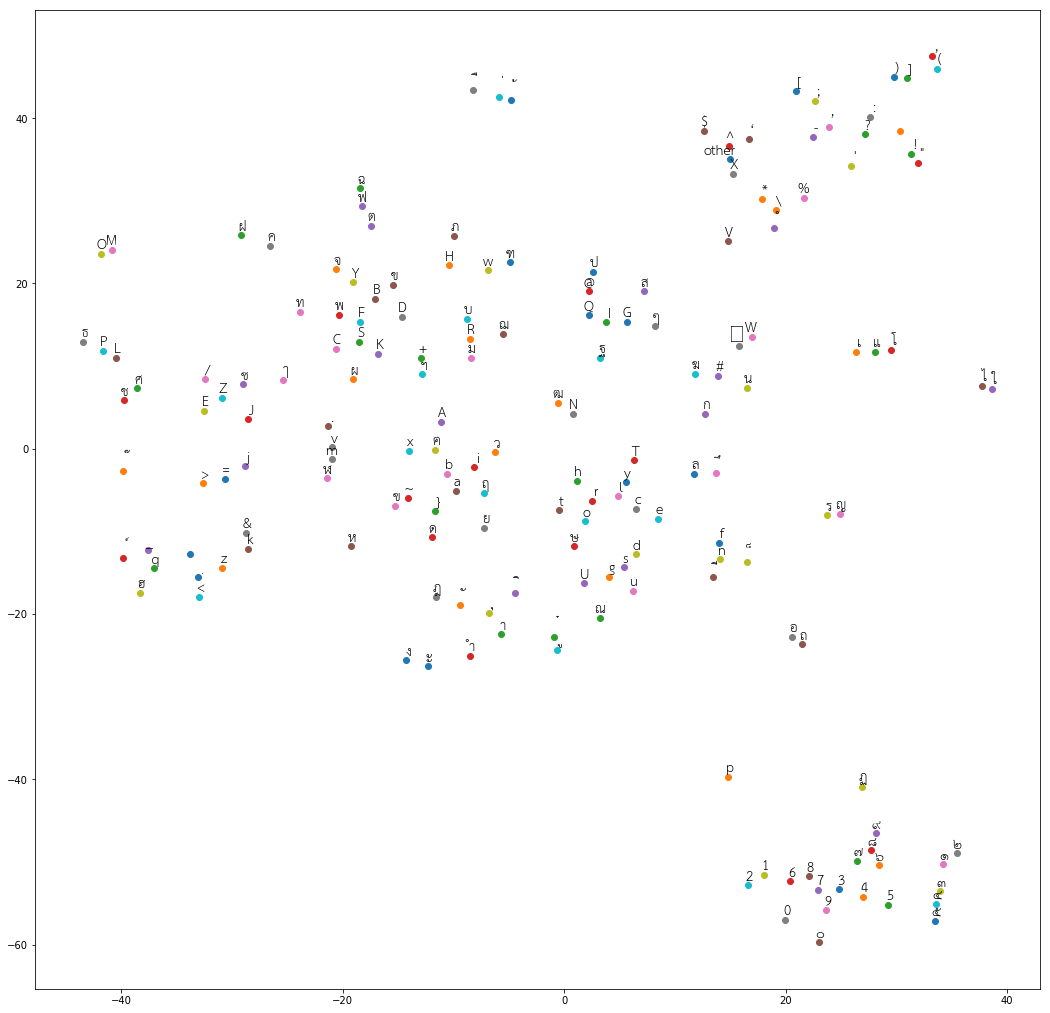

In [98]:
# Run t-SNE and plot the representation
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=1000, method='exact')
plot_only = 178
low_dim_embs = tsne.fit_transform(embedding_table)
labels = [CHARS[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Final Section
# Keras playground

Now, train the best model you can do for this task. You can use any model structure and function available. Remember that trainig time increases with the complexity of the model. You might find TensorBoard helpful in tuning of complicated models.

Your model should be better than your CNN or GRU model in the previous sections.

We will give you 2 bonus points if you can achieve more than 97.8% f-score on test set.
Another 3 bonus points will be awarded to the person with the highest f-score.

In [35]:
################################################################################
# TODO#7                                                                        #
# Write a function that returns keras your best model. You can use anything    #
# you want. The goal here is to create the best model you can think of.        #
# Your model should get f-score more than 97% from calling evaluate().         #
#                                                                              #
# Hint: You should read keras documentation to see the list of available       #
# layers and options you can use.                                              #
################################################################################
from keras.layers import LSTM

def get_my_best_model():
    input1 = Input(shape=(21,))
    x = Embedding(len(CHARS) + 1, 64, input_length=21)(input1)
    x = LSTM(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = TimeDistributed(Dense(5))(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
    
    return model

In [ ]:
################################################################################
# TODO#8                                                                        #
# Write code that call model.fit, or model.fit_generator if you have data      #
# generator, to train you models. Make sure you have validation_data as an     # 
# argument and use verbose=2 to generate one log line per epoch. Select your   #
# batch size carefully as it will affect your model's ability to converge and  #
# time needed for one epoch.                                                   #
#                                                                              #
# Hint: Read about callbacks_list argument on the documentation. You might     #
# find  ReduceLROnPlateau() and ModelCheckpoint() useful for your training     #
# process. Feel free to use any other callback function available.             #
################################################################################
# This is called to clear the original model session in order to use TensorBoard
K.clear_session()

my_best_model = get_my_best_model()
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

# Path to save model parameters
weight_path_my_best_model='/data/model_weight_my_best_model.h5'

# Training callbacks list
callbacks_list_my_best_model = [
        TensorBoard(log_dir='/data/Graph/ff_5', histogram_freq=1, write_graph=True, write_grads=True),
        ModelCheckpoint(
            weight_path_my_best_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
  ]

print('start training')
verbose = 1
train_params = [(3, 65536)]
for (epochs, batch_size) in train_params:
    print("train with {} epochs and {} batch size".format(epochs, batch_size))
    my_best_model.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                              callbacks=callbacks_list_my_best_model,
                              validation_data=(x_val_char, y_val))

In [ ]:
# Load saved model weight
weight_path_my_best_model='/data/model_weight_my_best_model.h5'
my_best_model = get_my_best_model()
my_best_model.load_weights(weight_path_my_best_model)

In [ ]:
my_best_model.summary()

In [ ]:
y_pred_5, f1score_5, precision_5, recall_5, accuracy_5 = evaluate(x_test_char, y_test, my_best_model)
print("F1 Score: {0:f}\nPrecision: {1:f}\nRecall: {2:f}\nAccuracy: {3:f}".format(f1score_5, precision_5, recall_5, accuracy_5))

In [ ]:
loss_5, accuracy_5 = my_best_model.evaluate(x_test_char, y_test, batch_size=65536, verbose=1)
print("\nLoss: {0:f}\nAccuracy: {1:f}".format(loss_5, accuracy_5))